<a href="https://colab.research.google.com/github/albercej/zug/blob/master/Exploring_relationships_between_news_and_market_data_using_time_series_analysis_public_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring relationships between news and market data using time series analysis 
By Parsa Ghaffari and Chris Hokamp - May 2022

In order to run the notebook in Colab successfully:

1. You'll need an AYLIEN News API key which can be obtained from https://aylien.com/product/news-api
2. You'll need to upload a logo.png file in the Files section (on the left hand side)

# 1. Fetch market and news data

In [11]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
# define tickers and date range

tickers = ["AAPL", "TSLA", "XLK", "PFE", "MRNA", "XPH", "^GSPC"] # Apple, Tesla, Tech industry ETF, Pfizer, Moderna, Pharma industry ETF, S&P index
start_date = "2021-04-01"
end_date = "2022-04-01"

data = {} # dict to hold all our market and news data

In [13]:
# fetch market data from Y! Finance

import yfinance as yf

for ticker in tickers:
    yfd = yf.download(ticker, start=start_date, end=end_date)
    data[ticker] = {'market': yfd}
    print(f"Fetching market data for: {ticker}")

[*********************100%***********************]  1 of 1 completed
Fetching market data for: AAPL
[*********************100%***********************]  1 of 1 completed
Fetching market data for: TSLA
[*********************100%***********************]  1 of 1 completed
Fetching market data for: XLK
[*********************100%***********************]  1 of 1 completed
Fetching market data for: PFE
[*********************100%***********************]  1 of 1 completed
Fetching market data for: MRNA
[*********************100%***********************]  1 of 1 completed
Fetching market data for: XPH
[*********************100%***********************]  1 of 1 completed
Fetching market data for: ^GSPC


In [14]:
import json
import requests
import time
import copy

HEADERS = {
    'X-AYLIEN-NewsAPI-Application-ID': 'YOUR_APP_ID', # Get your API key from https://aylien.com/product/news-api
    'X-AYLIEN-NewsAPI-Application-Key': 'YOUR_API_KEY',
}
TIMESERIES_ENDPOINT = 'https://api.aylien.com/news/time_series'

def retrieve_timeseries(
        params,
        n_pages=1,
        headers=HEADERS,
        endpoint=TIMESERIES_ENDPOINT,
        sleep=None):
    params = copy.deepcopy(params)
    response = requests.get(
        endpoint,
        params,
        headers=headers
    )
    return json.loads(response.text)

In [15]:
# Fetch news time series data for each ticker and 1. overall volume, 
# 2. positive sentiment volume, 3. negative sentiment volume

base_query = {
    "published_at.start": start_date + "T00:00:00Z",
    "published_at.end": end_date + "T00:00:00Z",
    "period": "+1DAY",
    "language": "en"
}

# News API queries for: "AAPL", "TSLA", "XLK", "PFE", "MRNA", "XPH", "^GSPC"
aqls = [
    "entities:({{id:Q312 AND overall_prominence:>=0.65}})",
    "entities:({{id:Q478214 AND overall_prominence:>=0.65}})",
    "industries:({{id:in.tech}})",
    "entities:({{id:Q206921 AND overall_prominence:>=0.65}})",
    "entities:({{id:Q17081612 AND overall_prominence:>=0.65}})",
    "industries:({{id:in.hcare.pharma}})",
    "categories:({{taxonomy:aylien AND id:ay.fin}})"
]

sentiments = [
    "positive",
    "negative"
]

assert len(tickers) == len(aqls), 'we\'re expecting one NewsAPI query for each ticker'
for ticker, aql in zip(tickers, aqls):
    print(f"Fetching news volume time series data for: {ticker}")
    time_series = retrieve_timeseries({**base_query, **{"aql": aql}})
    data[ticker].update({"news": {"volume": time_series["time_series"]}})
    for s in sentiments:
        print(f"Fetching news sentiment ({s}) time series data for: {ticker}")
        q = {**base_query, **{"aql": aqls}, **{"sentiment.title.polarity": s}}
        sts = retrieve_timeseries(q)
        data[ticker]["news"].update({"sentiment-" + s: sts["time_series"]})

Fetching news volume time series data for: AAPL


KeyError: ignored

In [8]:
import pandas as pd

def aylien_timeseries_to_df(aylien_ts):
    df = pd.DataFrame(aylien_ts)
    df = df.astype(
        {'published_at': 'datetime64[ns]', 'count': 'float'},
        copy=False
    )
    df.set_index('published_at', inplace=True)
    return df

In [9]:
# Convert news time series data to dataframes

for ticker in tickers:
    newsv_df = aylien_timeseries_to_df(data[ticker]["news"]["volume"])
    newssp_df = aylien_timeseries_to_df(data[ticker]["news"]["sentiment-positive"])
    newssn_df = aylien_timeseries_to_df(data[ticker]["news"]["sentiment-negative"])
    # let's add another df with the average sentiment 
    newssavg_df = (newssp_df.div(newssp_df.max(axis=0)['count'], axis=0) - newssn_df.div(newssn_df.max(axis=0)['count'], axis=0))/2

    data[ticker]["news"].update({
        "volume_df": newsv_df,
        "sentiment-positive_df": newssp_df,
        "sentiment-negative_df": newssn_df,
        "sentiment-average_df": newssavg_df
    })

KeyError: ignored

In [ ]:
# vanity (adding logo to the charts)
# Note: to run the notebook smoothly you need to have a logo.png file 🤷🏻‍♂️

from pathlib import Path
import matplotlib.cbook as cbook
import matplotlib.image as image

logo_path = Path('/content/logo.png')
im = image.imread(logo_path)

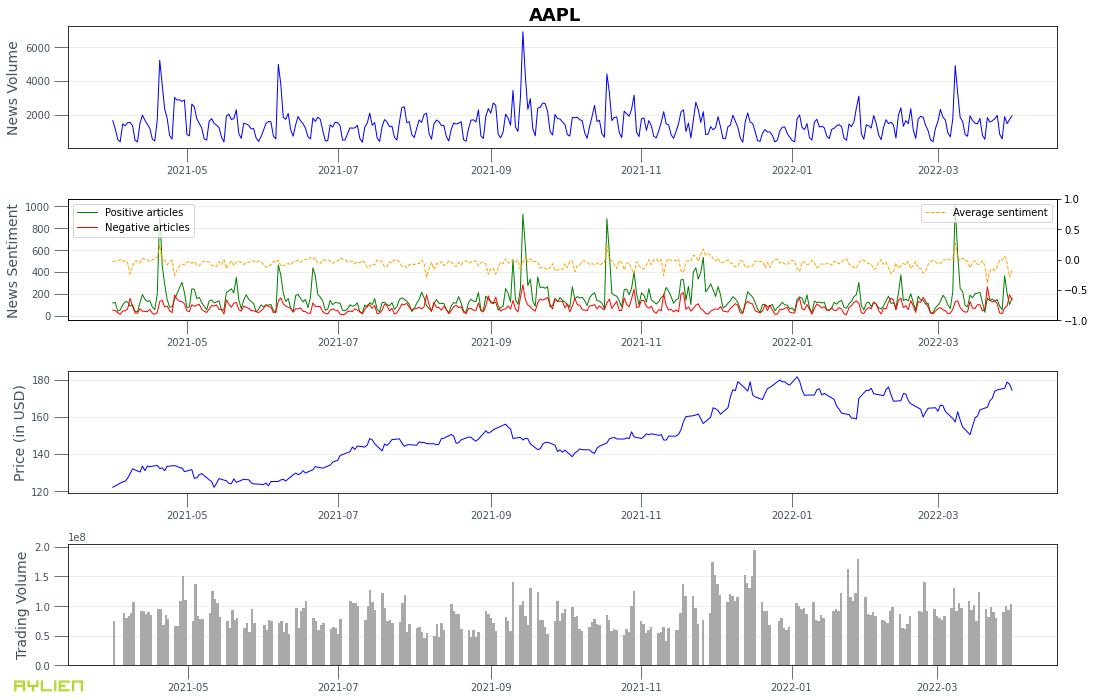

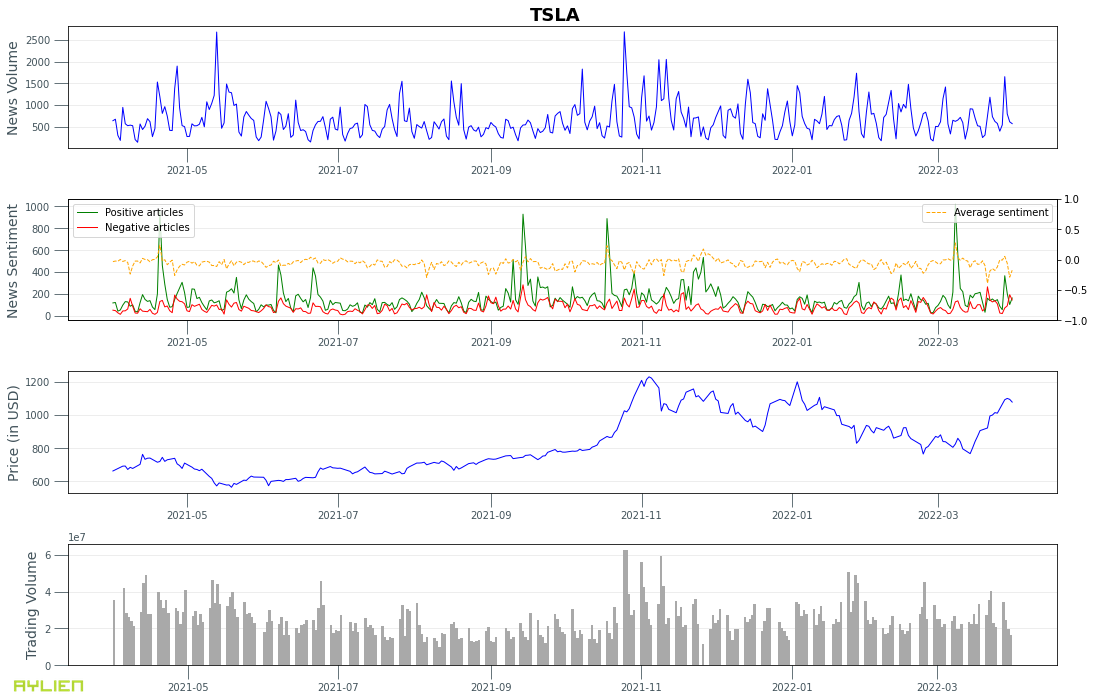

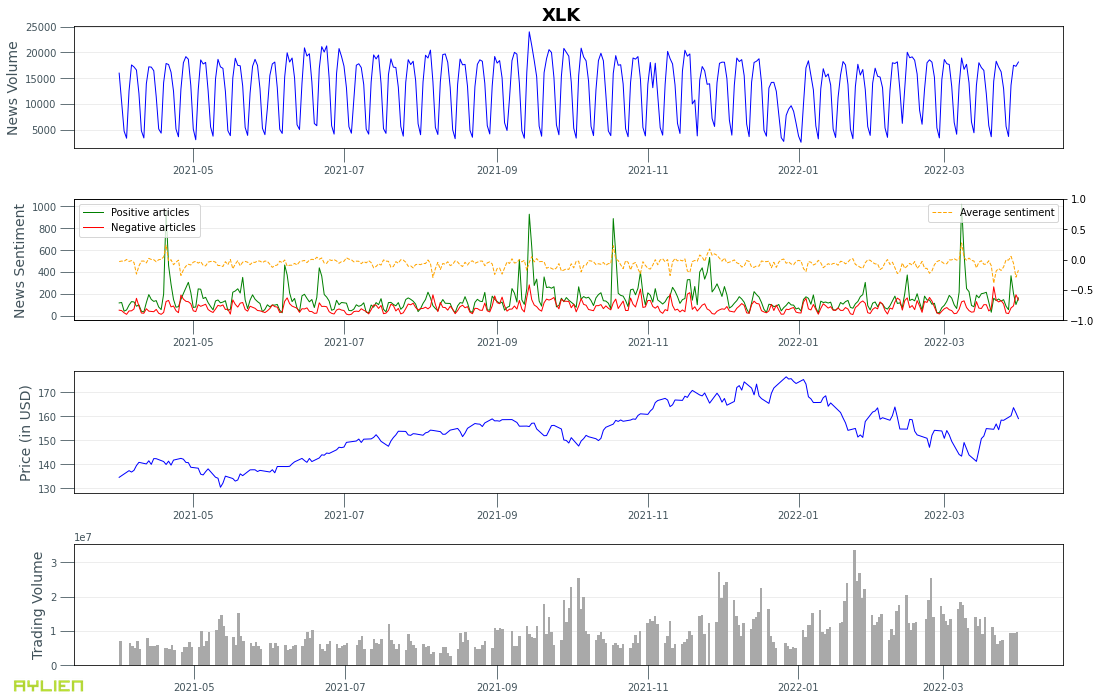

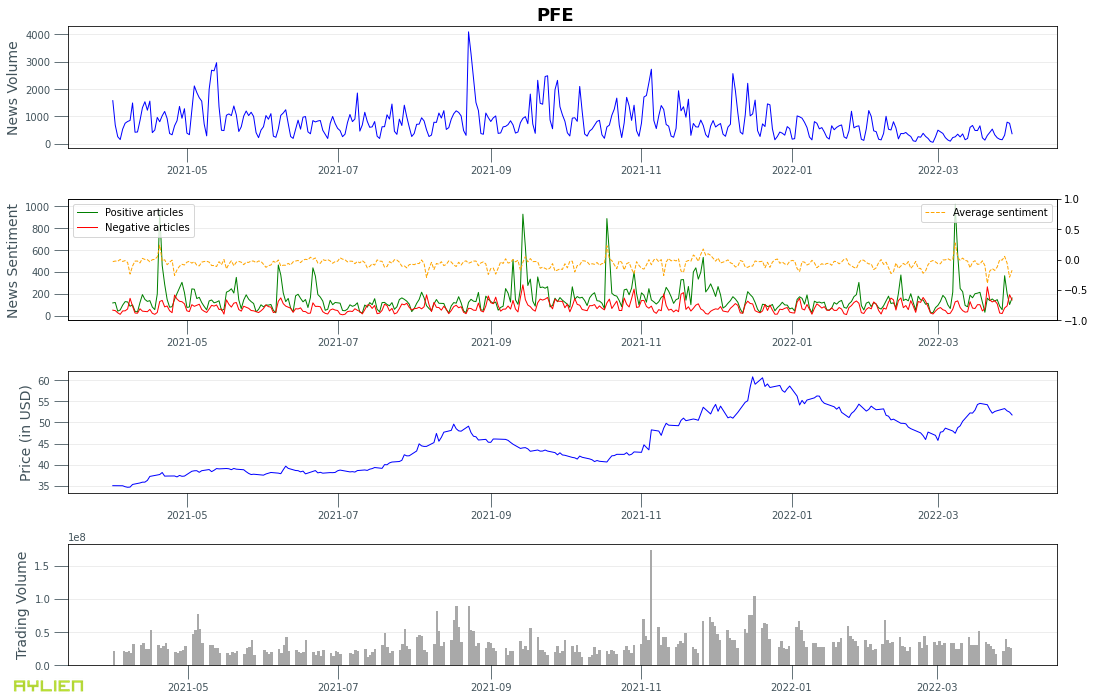

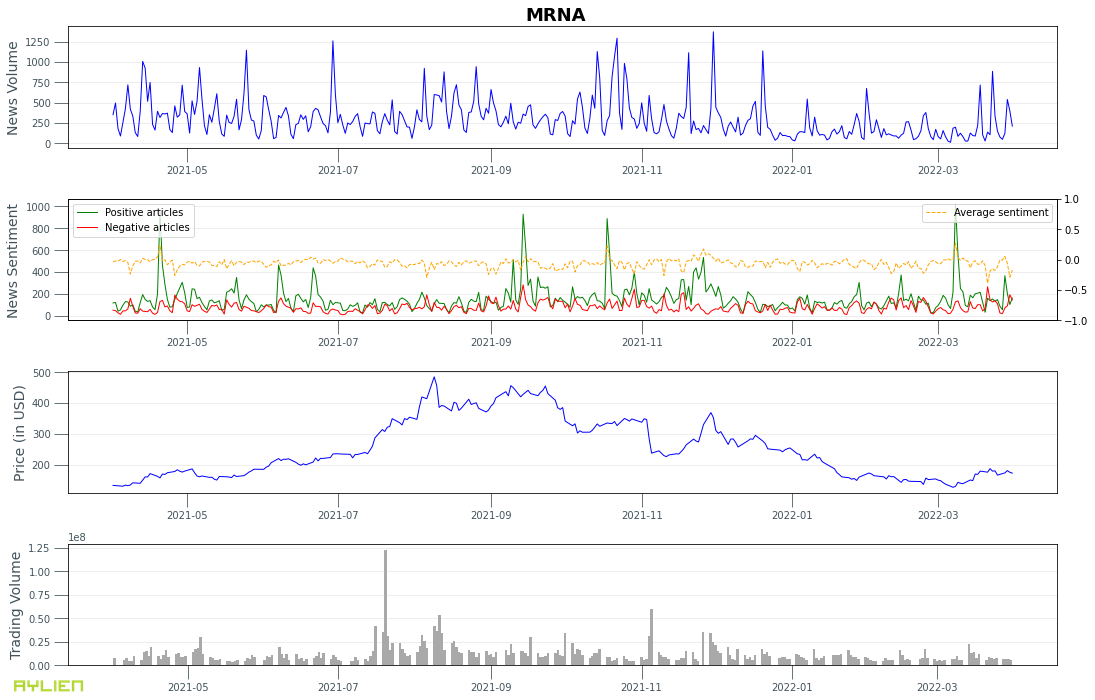

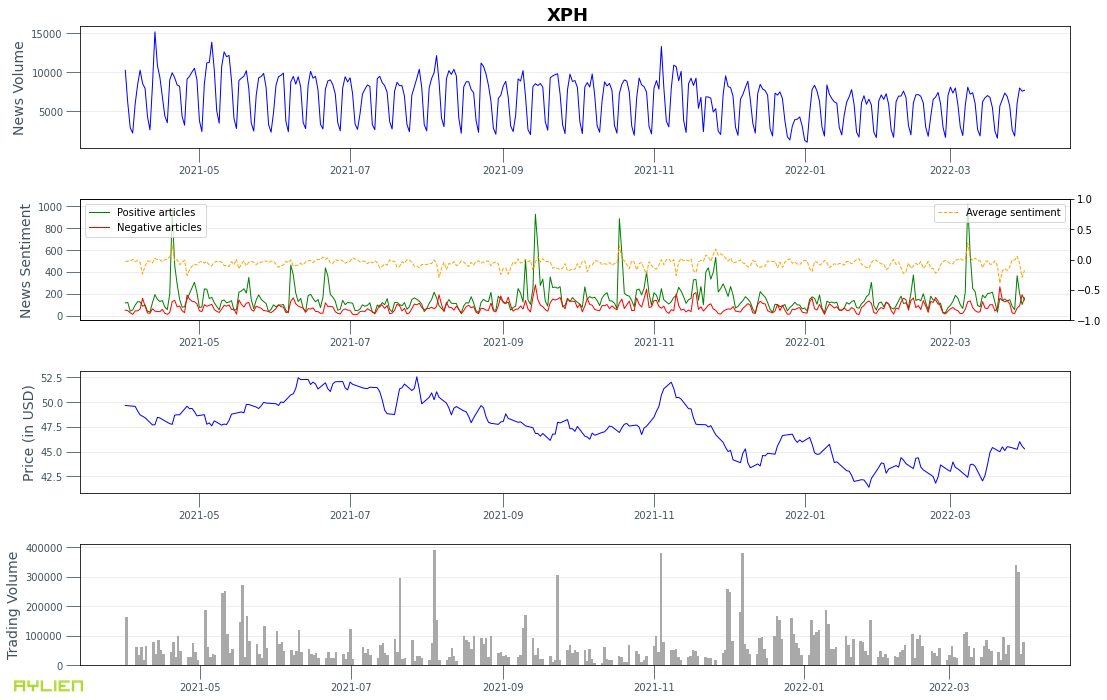

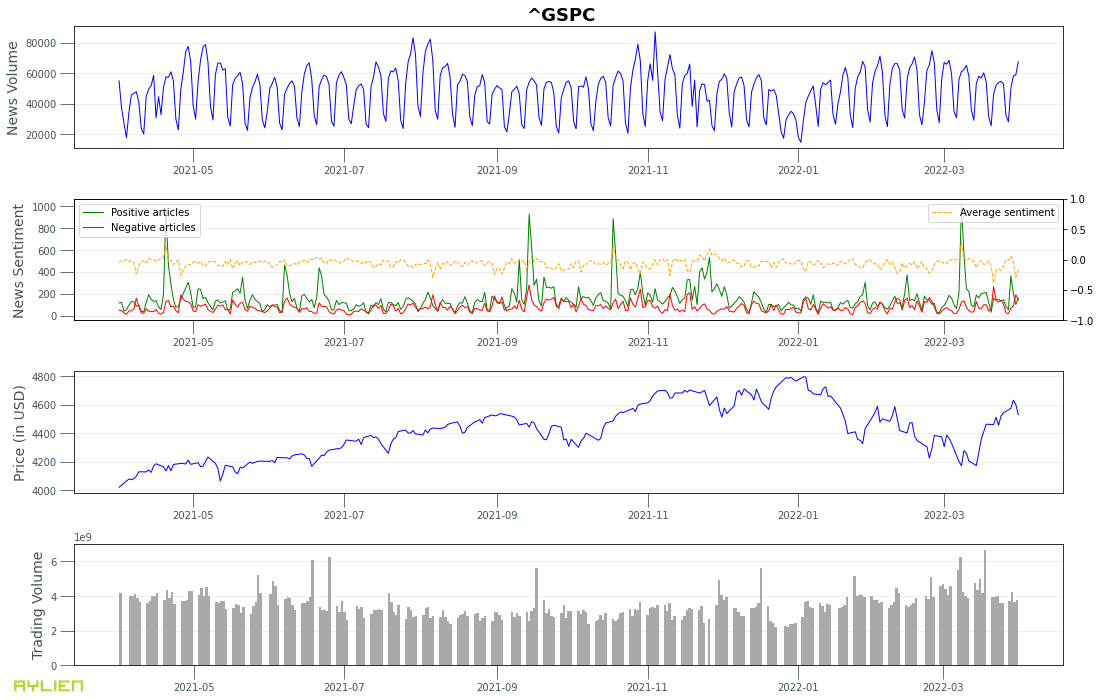

In [ ]:
# Plot news and market data on a single chart for each ticker

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

colors = {'red': '#ff207c', 'grey': '#42535b', 'blue': '#207cff', 'orange': '#ffa320', 'green': '#00ec8b'}
config_ticks = {'size': 14, 'color': colors['grey'], 'labelcolor': colors['grey']}
config_title = {'size': 18, 'color': colors['grey'], 'ha': 'left', 'va': 'baseline'}

for ticker in tickers:
    newsv_df = data[ticker]["news"]["volume_df"]
    newssp_df = data[ticker]["news"]["sentiment-positive_df"]
    newssn_df = data[ticker]["news"]["sentiment-negative_df"]
    newssavg_df = data[ticker]["news"]["sentiment-average_df"]
    market_df = data[ticker]["market"]

    plt.rc('figure', figsize=(15, 10))

    fig, axes = plt.subplots(4, 1)
    fig.tight_layout(pad=3)
    fig.suptitle(ticker, fontweight='bold', fontsize=18)
    fig.figimage(im, 10, 0, zorder=3, alpha=.8)

    plot_newsv = axes[0]
    plot_newsv.tick_params(axis='both', **config_ticks)
    plot_newsv.set_ylabel('News Volume', fontsize=14)
    plot_newsv.yaxis.label.set_color(colors['grey'])
    plot_newsv.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_newsv.set_axisbelow(True)
    plot_newsv.plot(newsv_df['count'], color='blue', linewidth=1, label='News volume')

    plot_newss = axes[1]
    plot_newss.tick_params(axis='both', **config_ticks)
    plot_newss.set_ylabel('News Sentiment', fontsize=14)
    plot_newss.yaxis.label.set_color(colors['grey'])
    plot_newss.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_newss.set_axisbelow(True)
    plot_newss.plot(newssp_df['count'], color='green', linewidth=1, label='Positive articles')
    plot_newss.plot(newssn_df['count'], color='red', linewidth=1, label='Negative articles')
    plot_newss.legend(loc="upper left")

    plot_newssavg = plot_newss.twinx()
    plot_newssavg.plot(newssavg_df['count'], color='orange', linewidth=1, label='Average sentiment', ls='--')
    plot_newssavg.axes.set_ylim(-1,1)
    plot_newssavg.legend(loc="upper right")

    plot_price = axes[2]
    plot_price.tick_params(axis='both', **config_ticks)
    plot_price.set_ylabel('Price (in USD)', fontsize=14)
    plot_price.yaxis.label.set_color(colors['grey'])
    plot_price.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_price.set_axisbelow(True)
    plot_price.plot(market_df["Adj Close"], color='blue', linewidth=1, label='Price')

    plot_volume = axes[3]
    plot_volume.tick_params(axis='both', **config_ticks)
    plot_volume.set_ylabel('Trading Volume', fontsize=14)
    plot_volume.yaxis.label.set_color(colors['grey'])
    plot_volume.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_volume.set_axisbelow(True)
    plot_volume.bar(market_df.index, height=market_df["Volume"], color='darkgrey', width=1, label='Volume')

# **2. Time Series Analysis**

In [ ]:
!pip install kats

     |████████████████████████████████| 612 kB 27.3 MB/s 
     |████████████████████████████████| 950 kB 38.4 MB/s 
     |████████████████████████████████| 310 kB 57.8 MB/s 
     |████████████████████████████████| 3.3 MB 64.2 MB/s 
     |████████████████████████████████| 9.5 MB 42.0 MB/s 
     |████████████████████████████████| 347 kB 51.9 MB/s 
     |████████████████████████████████| 34.5 MB 15 kB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=81c097e6575807b0e59e74d00670463bb4a0951791b511718758c51f7df91958
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Success

In [ ]:
from kats.consts import TimeSeriesData
from kats.utils.decomposition import TimeSeriesDecomposition

In [ ]:
apple_news_df = data["AAPL"]["news"]["volume_df"]
ts = TimeSeriesData(apple_news_df.reset_index().rename(columns={'published_at': 'time', 'count': 'value'}), time_col_name="time")

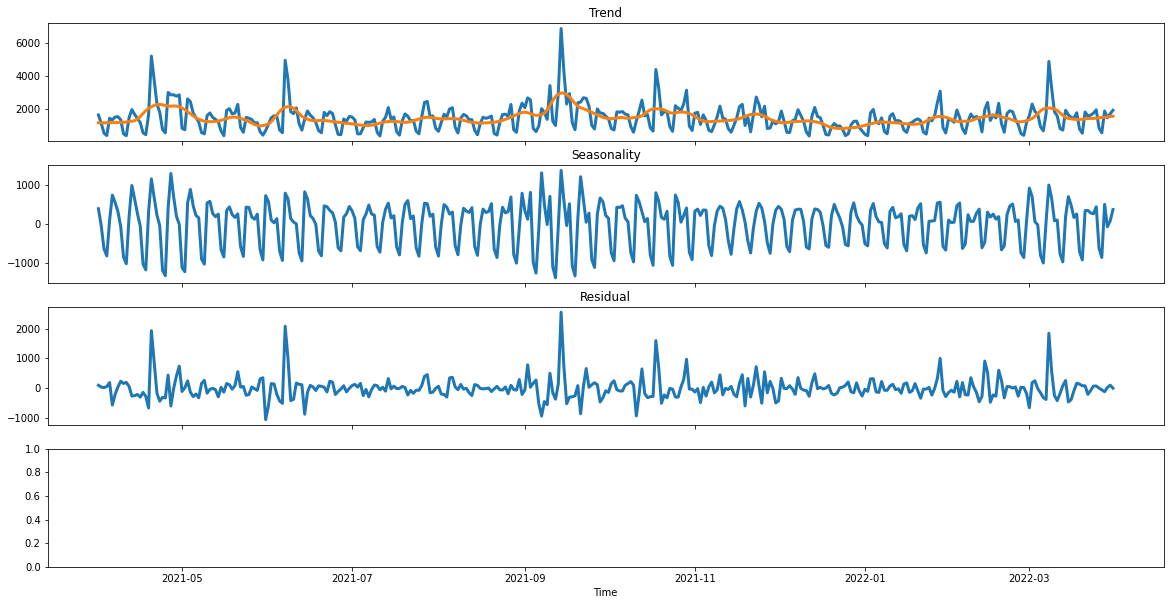

In [ ]:
decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
decomposed = decomposer.decomposer()
fig = decomposer.plot()

# 2.1. Forecasting

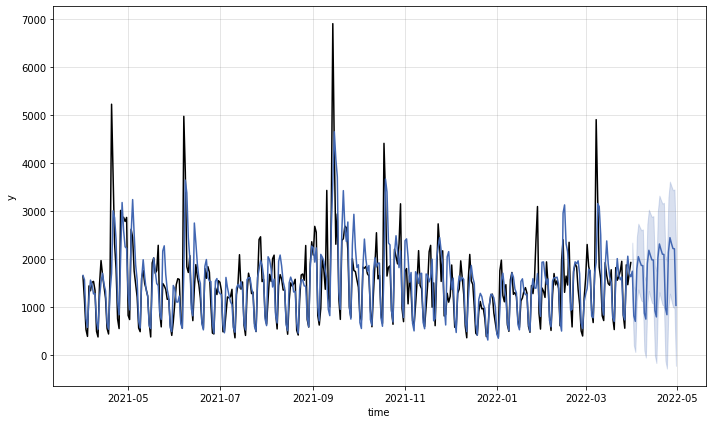

In [ ]:
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
import warnings

warnings.simplefilter(action='ignore')

params = HoltWintersParams(
    trend="add",
    seasonal="mul",
    seasonal_periods=7,
)
m = HoltWintersModel(
    data=ts, 
    params=params
)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1, include_history=True)
m.plot()

# 2.2 Detection

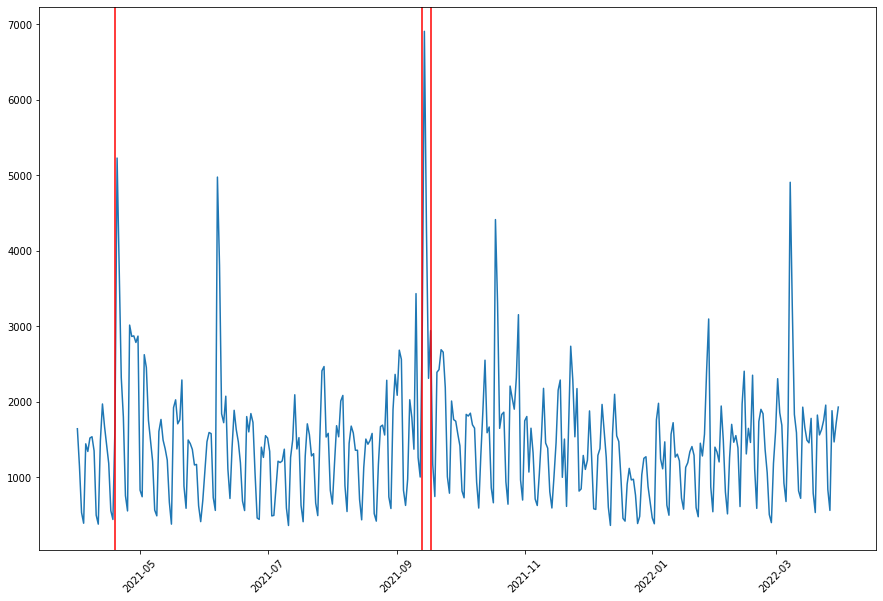

In [ ]:
from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, TrendChangeParameters

# Initialize the detector
detector = BOCPDetector(ts)

changepoints = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL
)

# Plot the data
detector.plot(changepoints)
plt.xticks(rotation=45)

plt.show()

# 2.3. Anomalies

In [ ]:
# Shamelessly stolen from Chris Hokamp :)

!pip install arrow
from kats.consts import TimeSeriesData
import arrow
from kats.utils.decomposition import TimeSeriesDecomposition
import matplotlib.dates as mdates
cmap = matplotlib.cm.coolwarm

def datetime_to_aylien_str(dt):
    """
    Convert python datetime object to the string format
    used by Aylien newsAPI
    """
    dt_str = dt.isoformat().split('+')[0]
    if 'T' not in dt_str:
        dt_str = f'{dt_str}T00:00:00.0'
    dt_str = f'{dt_str}Z'

    return dt_str

class TimeWindowDetectorConfig:
    def __init__(self, args: dict):
        pass

class TimeWindowDetector:
    def __init__(self, config):
        self.decomposition = \
            config.get('decomposition', 'additive')

    @classmethod
    def from_config(cls, args: dict):
        return cls(TimeWindowDetectorConfig(args))

    def decompose(self, tsd):
        return TimeSeriesDecomposition(tsd, decomposition=self.decomposition)

    def windows_of_interest(self, tsd, ts='value', whisker_width=1.5,
                            window_range=1, min_delta=3, min_iqr=5,
                            format='datetime'):
        """
        Given a Kats TimeSeriesData object, return windows of interest
        by detecting points that are outside the interquartile range
        after correcting timeseries for trend and seasonality.

        :param tsd: Kats TimeSeriesData
        :param ts: one of: 'value' or 'rem', if 'rem',
        we do decomposition
        :param whisker_width: factor for finding outlier according to
        interquartile range
        :param window_range: expand timewindows to the left and right
        by this amount
        :param min_delta: consecutive windows within this delta are
        merged into a single window
        :param min_delta: consecutive windows within this delta are
        merged into a single window
        :param min_iqr: the minimum interquartile range, this is relevant
        for very low-volume timeseries
        :param format: one of {'datetime' | 'isoformat'}, specifying the
        output type for time window dates
        :return: [(start_date, end_date), ...]
        """
        assert ts in ['value', 'rem']
        assert format in ['datetime', 'isoformat']
        if ts == 'rem':
            decomposed = self.decompose(tsd).decomposer()
            rem_df = decomposed['rem'].to_dataframe()
        else:
            # rename column to match decomposed df
            rem_df = tsd.to_dataframe().rename(
                columns={'value': 'resid'}
            )

        # TODO: switch to rolling quantile
        # Calculate Q1, Q2 and IQR
        q1 = rem_df['resid'].quantile(0.25)
        q3 = rem_df['resid'].quantile(0.75)
        iqr = q3 - q1
        if iqr < min_iqr:
            iqr = min_iqr

        # Apply filter with respect to IQR, including optional whiskers
        # We're looking for values that are greater than IQR by some factor
        filter = rem_df['resid'] >= q3 + whisker_width*iqr
        # note "relative" outlier weights -- we may want to change
        # to a static function such as distance from threshold
        values = (rem_df.loc[filter]['resid'].to_numpy()
                  - (q3 + whisker_width*iqr))
        if len(values):
            # smooth
            values = values + 1
            # normalize to range (0,1]
            values = values / values.max()

        significant_df = rem_df.loc[filter]
        significant_dates = [arrow.get(d) for d in significant_df['time']]
        assert len(values) == len(significant_dates)

        windows = []
        weights = []
        prev = None
        # note assumption that dates are chronological
        for current, value in zip(significant_dates, values):
            if prev is not None and \
                    (current - prev).days <= min_delta:
                windows[-1][1] = current
                weights[-1] = max(weights[-1], value)
            else:
                windows.append([current, current])
                weights.append(value)
            prev = current

        # widen windows by shifting start and end
        windows = \
            [(sd.shift(days=-window_range), ed.shift(days=+window_range))
             for sd, ed in windows]
        if format == 'datetime':
            return [(sd.datetime, ed.datetime) for sd, ed in windows], weights
        else:
            # isoformat
            return [
                (datetime_to_aylien_str(sd.datetime),
                 datetime_to_aylien_str(ed.datetime))
                for sd, ed in windows
            ], weights

     |████████████████████████████████| 64 kB 2.1 MB/s 


In [ ]:
# Initiate detector 

detector = TimeWindowDetector(config={})

In [ ]:
# Convert dataframes to kats time series for each ticker

for ticker in tickers:
    newsv_ts = TimeSeriesData(data[ticker]["news"]["volume_df"].reset_index().rename(columns={'published_at': 'time', 'count': 'value'}), time_col_name="time")
    newssp_ts = TimeSeriesData(data[ticker]["news"]["sentiment-positive_df"].reset_index().rename(columns={'published_at': 'time', 'count': 'value'}), time_col_name="time")
    newssn_ts = TimeSeriesData(data[ticker]["news"]["sentiment-negative_df"].reset_index().rename(columns={'published_at': 'time', 'count': 'value'}), time_col_name="time")
    newssavg_ts = TimeSeriesData(data[ticker]["news"]["sentiment-average_df"].reset_index().rename(columns={'published_at': 'time', 'count': 'value'}), time_col_name="time")
  
    marketp_ts = TimeSeriesData(data[ticker]["market"]["Adj Close"].reset_index().rename(columns={'Date': 'time', 'Adj Close': 'value'}), time_col_name="time")
    marketv_ts = TimeSeriesData(data[ticker]["market"]["Volume"].reset_index().rename(columns={'Date': 'time', 'Volume': 'value'}), time_col_name="time")

    data[ticker]["news"].update({
        "volume_ts": newsv_ts,
        "sentiment-positive_ts": newssp_ts,
        "sentiment-negative_ts": newssn_ts,
        "sentiment-average_ts": newssavg_ts,
    })

    data[ticker].update({
        "market_ts": { # TODO: refactor to add market_df and market_ts to market
        "price_ts": marketp_ts,
        "volume_ts": marketv_ts
      }
    })

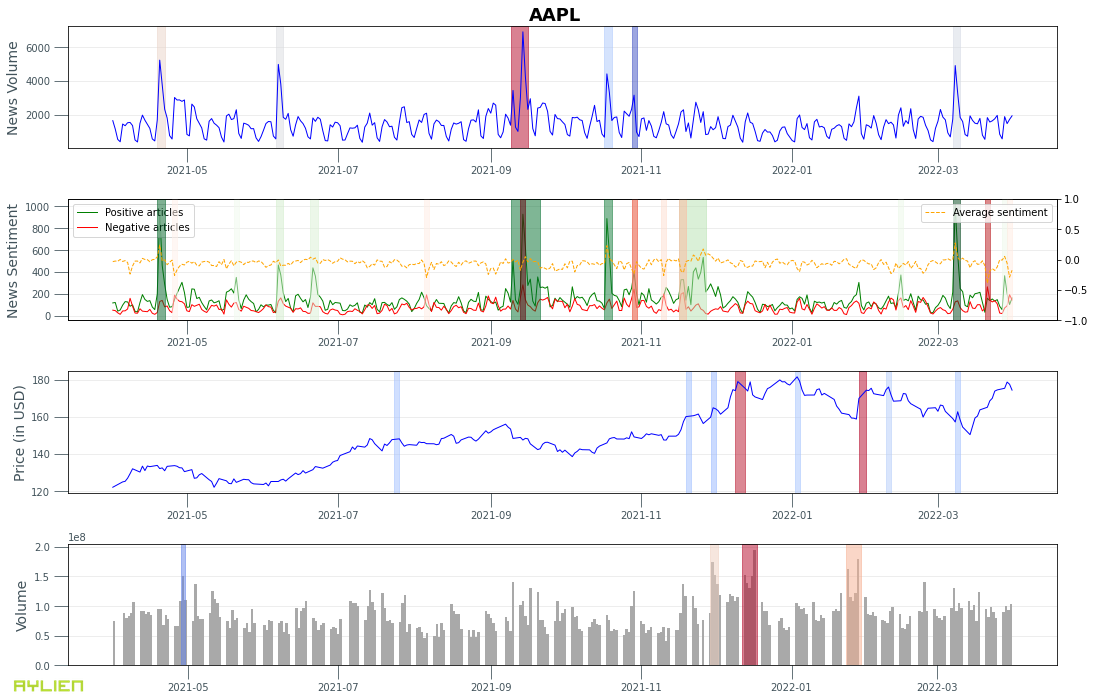

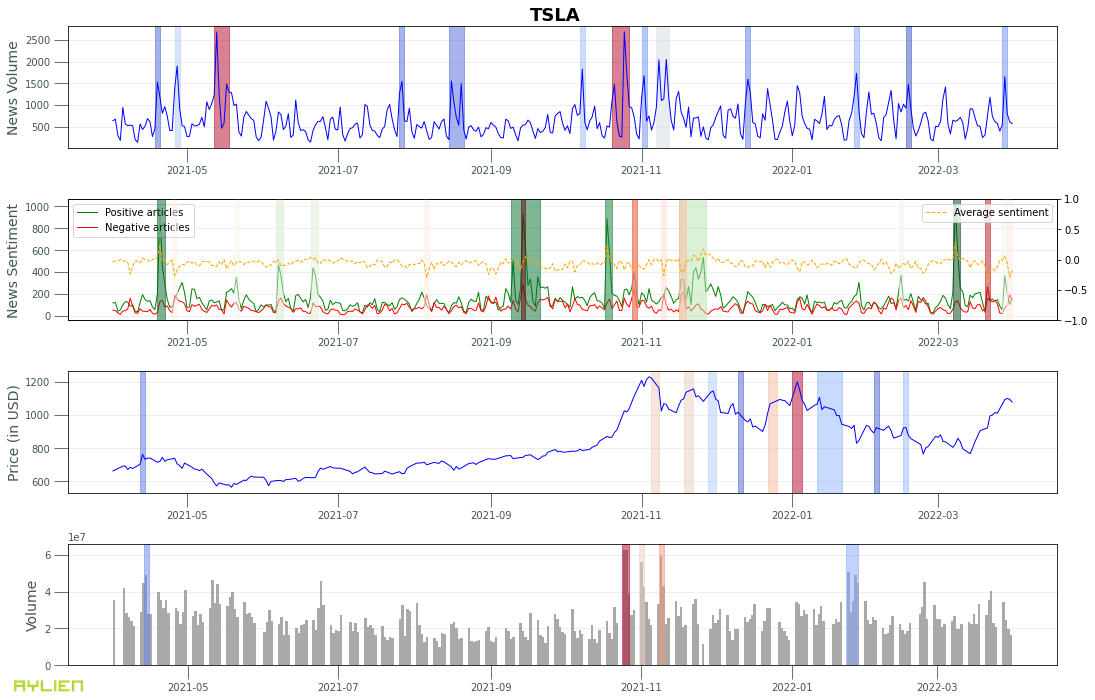

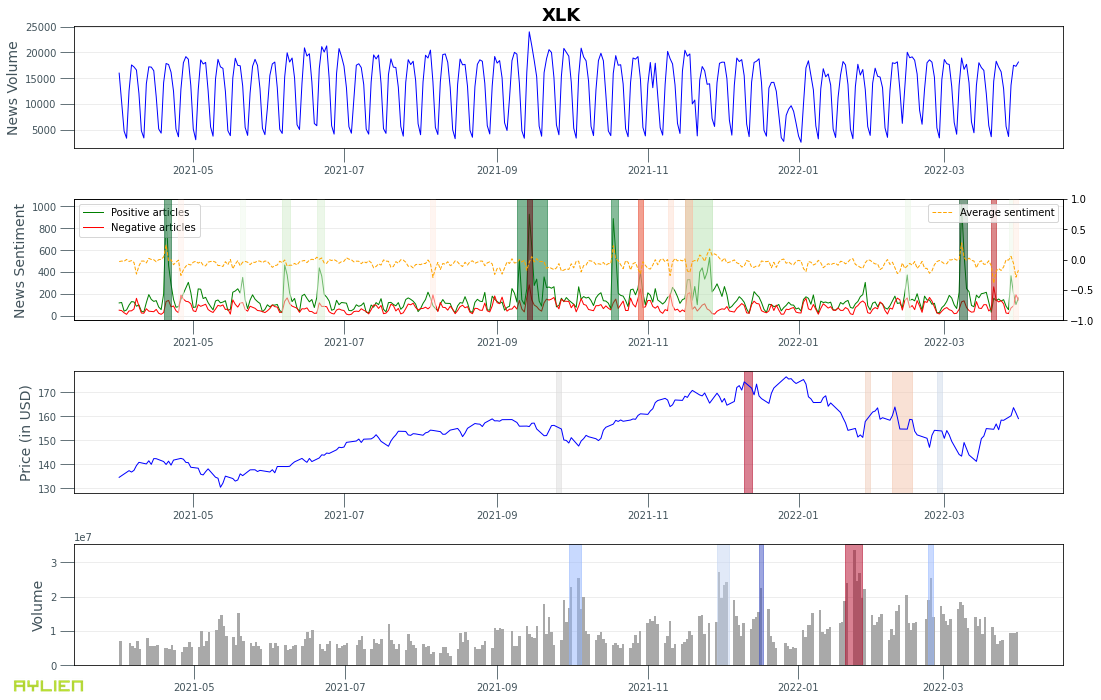

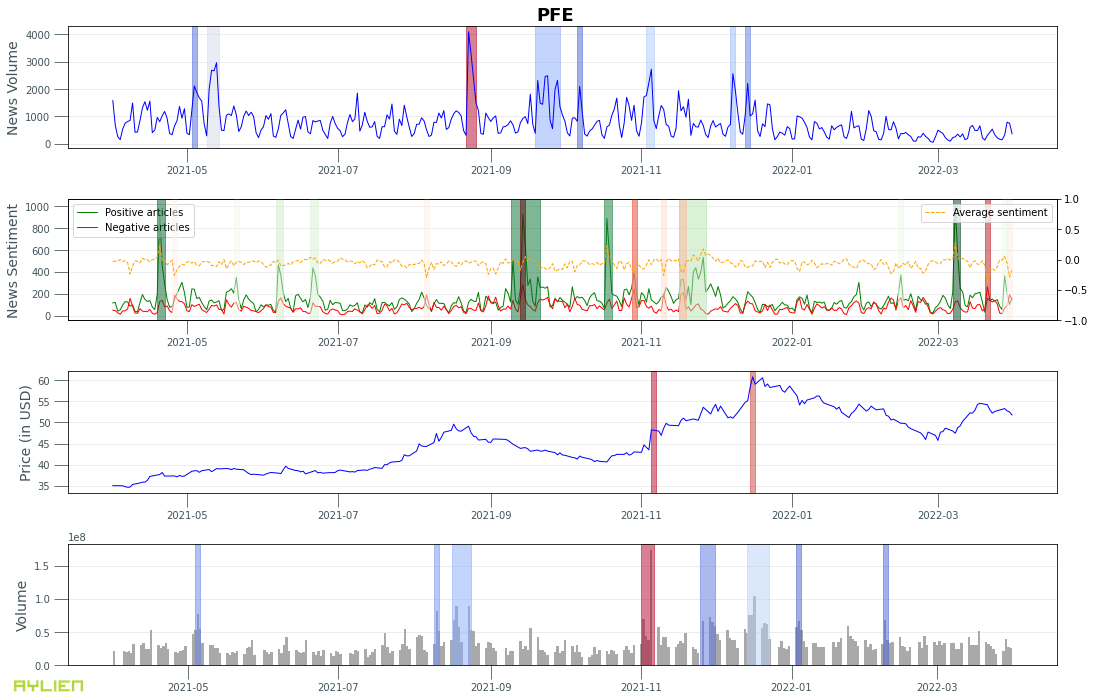

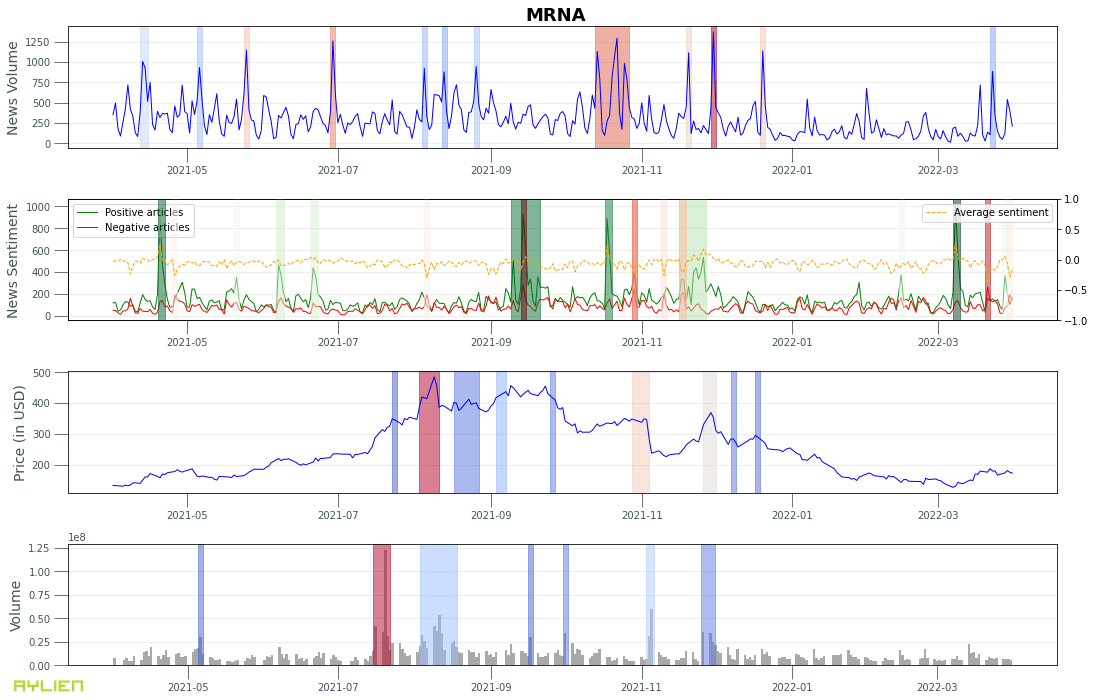

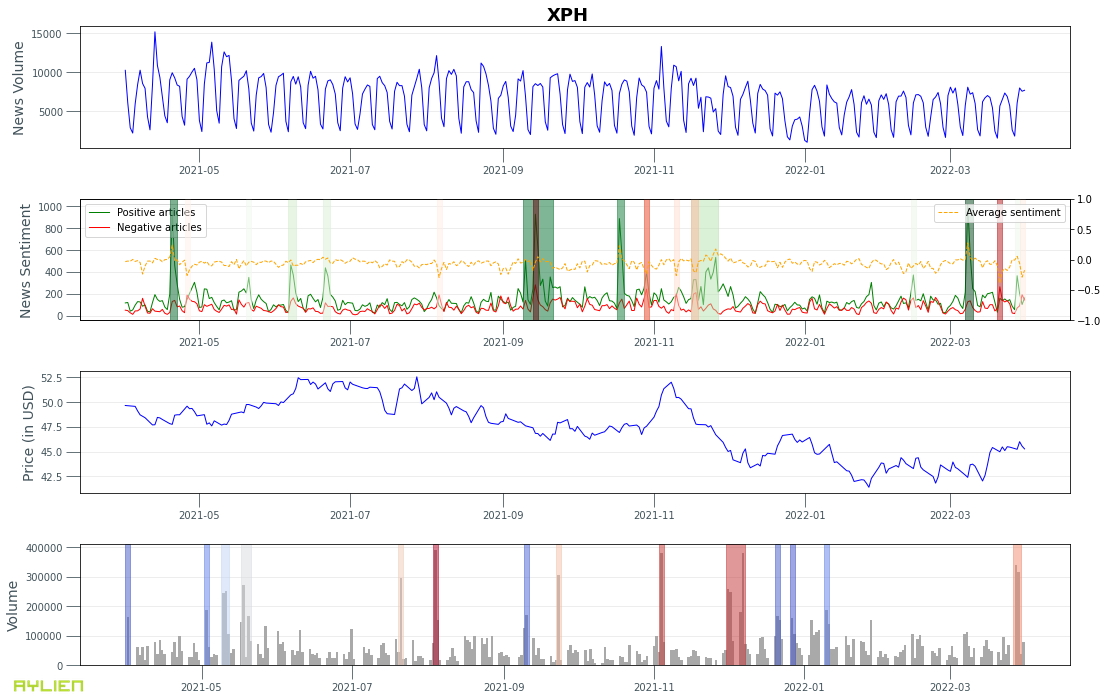

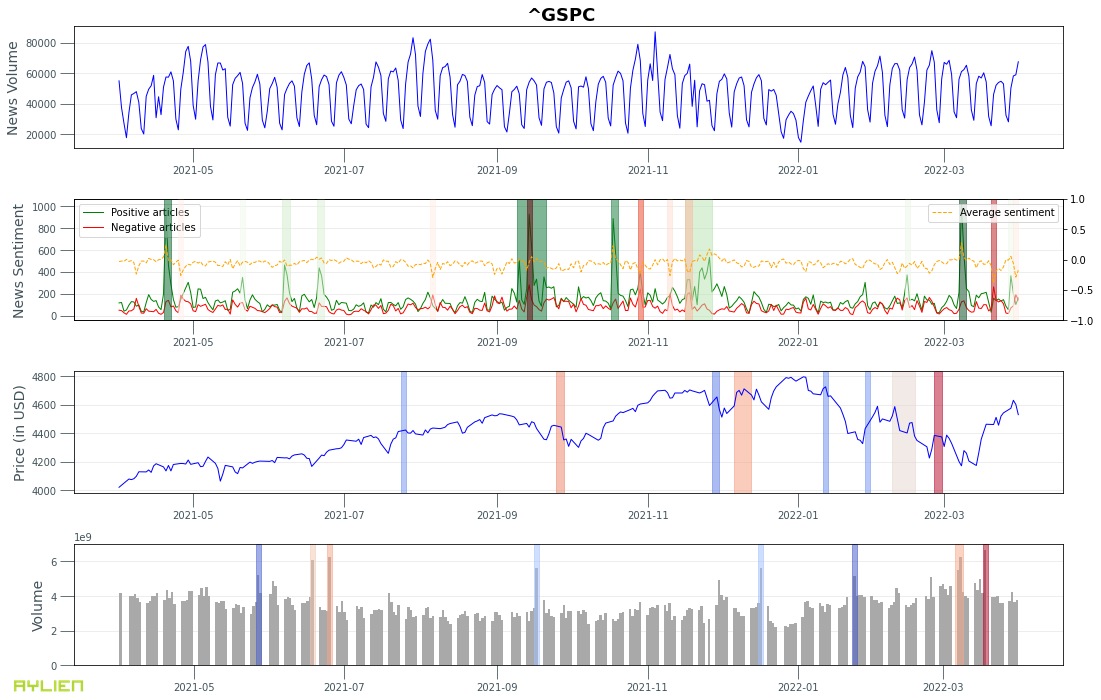

In [ ]:
# Plot news and market data on a single chart for each ticker, with anomalies overlayed

for ticker in tickers:
    newsv_df = data[ticker]["news"]["volume_df"]
    newssp_df = data[ticker]["news"]["sentiment-positive_df"]
    newssn_df = data[ticker]["news"]["sentiment-negative_df"]
    newssavg_df = data[ticker]["news"]["sentiment-average_df"]
    market_df = data[ticker]["market"]

    newsv_ts = data[ticker]["news"]["volume_ts"]
    newssp_ts = data[ticker]["news"]["sentiment-positive_ts"]
    newssn_ts = data[ticker]["news"]["sentiment-negative_ts"]
    newssavg_ts = data[ticker]["news"]["sentiment-average_ts"]
  
    price_ts = data[ticker]["market_ts"]["price_ts"]
    volume_ts = data[ticker]["market_ts"]["volume_ts"]

    wois = []

    for ts in [newsv_ts, newssp_ts, newssn_ts, newssavg_ts, volume_ts]:
        interesting_windows, weights = detector.windows_of_interest(
            ts,
            whisker_width=1.5,
            window_range=1,
            min_delta=5
        )
        wois.append((interesting_windows, weights))

    for ts in [price_ts]:
        decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
        decomposed = decomposer.decomposer()

        interesting_windows, weights = detector.windows_of_interest(
            decomposed['rem'],
            whisker_width=1,
            window_range=1,
            min_delta=5,
            min_iqr=2
        )
        wois.append((interesting_windows, weights))

    plt.rc('figure', figsize=(15, 10))

    fig, axes = plt.subplots(4, 1)
    fig.tight_layout(pad=3)
    fig.suptitle(ticker, fontweight='bold', fontsize=18)
    fig.figimage(im, 10, 0, zorder=3, alpha=.8)

    plot_newsv = axes[0]
    plot_newsv.tick_params(axis='both', **config_ticks)
    plot_newsv.set_ylabel('News Volume', fontsize=14)
    plot_newsv.yaxis.label.set_color(colors['grey'])
    plot_newsv.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_newsv.set_axisbelow(True)
    plot_newsv.plot(newsv_df['count'], color='blue', linewidth=1, label='News volume')
    # add windows of interest
    for (start, end), weight in zip(wois[0][0], wois[0][1]):
        plot_newsv.axvspan(
            mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
            mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
            color=cmap(weight), alpha=0.5)

    plot_newss = axes[1]
    plot_newss.tick_params(axis='both', **config_ticks)
    plot_newss.set_ylabel('News Sentiment', fontsize=14)
    plot_newss.yaxis.label.set_color(colors['grey'])
    plot_newss.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_newss.set_axisbelow(True)
    plot_newss.plot(newssp_df['count'], color='green', linewidth=1, label='Positive articles')
    plot_newss.plot(newssn_df['count'], color='red', linewidth=1, label='Negative articles')
    plot_newss.legend(loc="upper left")

    plot_newssavg = plot_newss.twinx()
    plot_newssavg.plot(newssavg_df['count'], color='orange', linewidth=1, label='Average sentiment', ls='--')
    plot_newssavg.axes.set_ylim(-1,1)
    plot_newssavg.legend(loc="upper right")
    # add windows of interest
    for (start, end), weight in zip(wois[1][0], wois[1][1]):
        plot_newssavg.axvspan(mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
                mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
                color=matplotlib.cm.Greens(weight), alpha=0.5)
    for (start, end), weight in zip(wois[2][0], wois[2][1]):
        plot_newssavg.axvspan(mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
                mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
                color=matplotlib.cm.Reds(weight), alpha=0.5)

    plot_price = axes[2]
    plot_price.tick_params(axis='both', **config_ticks)
    plot_price.set_ylabel('Price (in USD)', fontsize=14)
    plot_price.yaxis.label.set_color(colors['grey'])
    plot_price.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_price.set_axisbelow(True)
    plot_price.plot(market_df["Adj Close"], color='blue', linewidth=1, label='Price')
    # add windows of interest
    for (start, end), weight in zip(wois[5][0], wois[5][1]):
        plot_price.axvspan(mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
                mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
                color=cmap(weight), alpha=0.5)

    plot_volume = axes[3]
    plot_volume.tick_params(axis='both', **config_ticks)
    plot_volume.set_ylabel('Volume', fontsize=14)
    plot_volume.yaxis.label.set_color(colors['grey'])
    plot_volume.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_volume.set_axisbelow(True)
    plot_volume.bar(market_df.index, height=market_df["Volume"], color='darkgrey', width=1, label='Volume')
    # add windows of interest
    for (start, end), weight in zip(wois[4][0], wois[4][1]):
        plot_volume.axvspan(mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
                mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
                color=cmap(weight), alpha=0.5)

# 2.4. Correlations

The Beta of an asset is a measure of the sensitivity of its returns relative to a market benchmark (usually a market index). R squared determines how much of a stock's movement can be explained by movements in the market.

Could also be applied to trade volumes...

In [ ]:
# Define function for calculting beta and r squared between any 2 tickers over a rolling window

from statsmodels.regression.rolling import RollingOLS


def calc_beta_rsquared(ticker1_df, ticker2_df, window):
    df = pd.DataFrame({'y': ticker1_df.pct_change(),
                       'x': ticker2_df.pct_change()})

    model = RollingOLS.from_formula('y ~ x', data = df, window=window)
    reg_obj = model.fit()

    beta = reg_obj.params['x']
    r_squared = reg_obj.rsquared
    return (beta, r_squared)

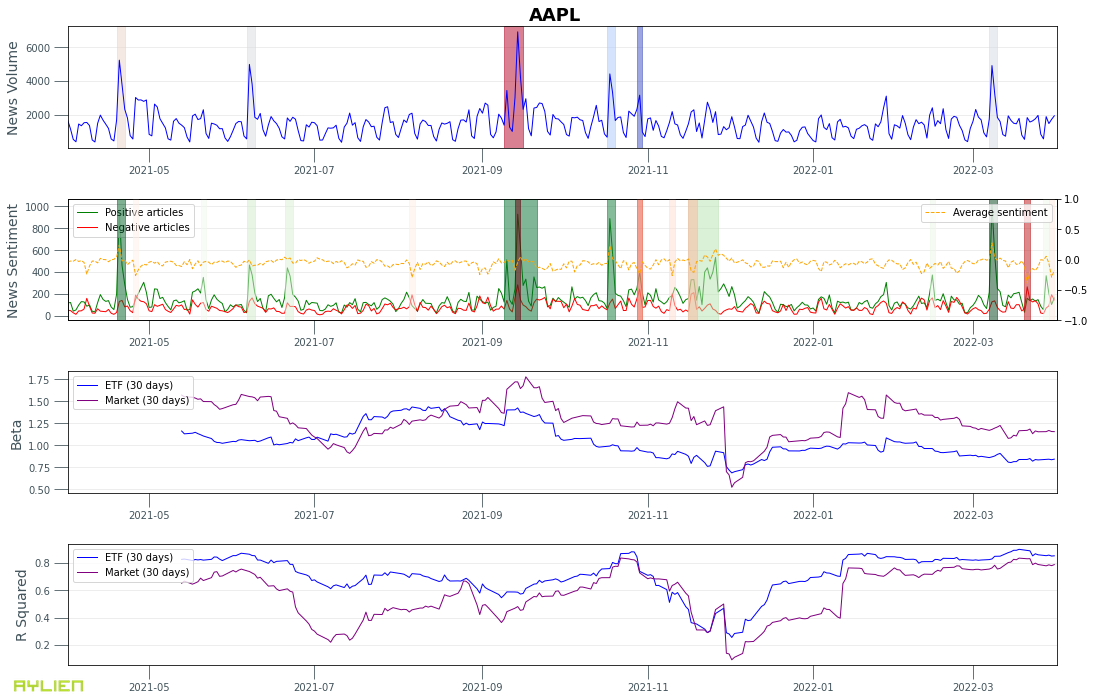

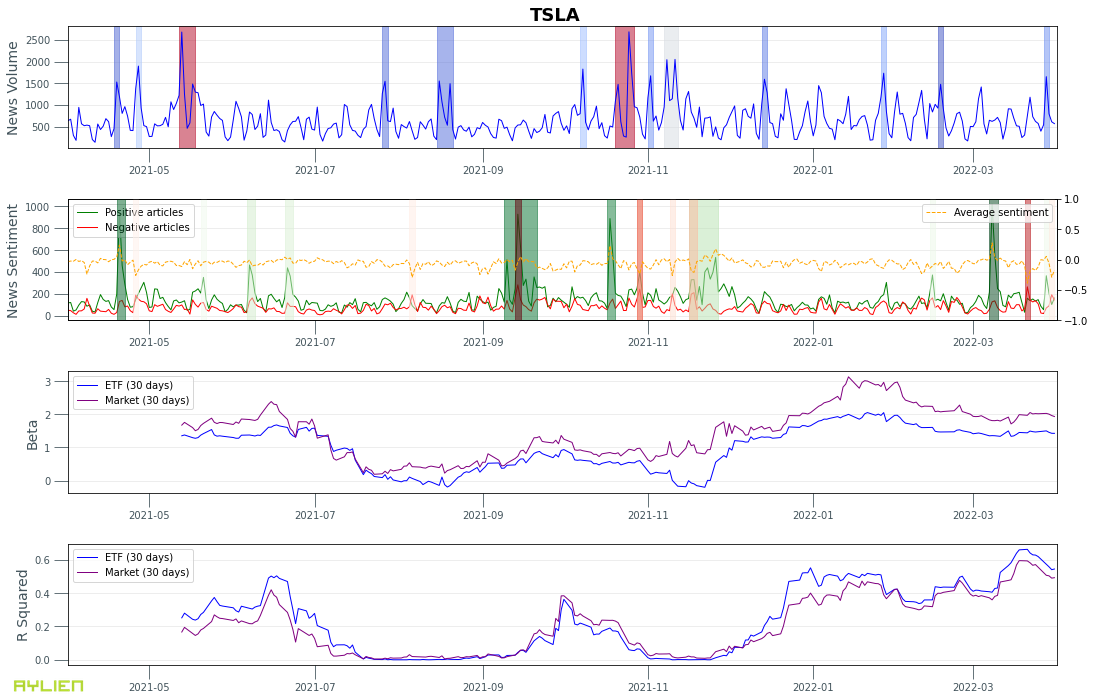

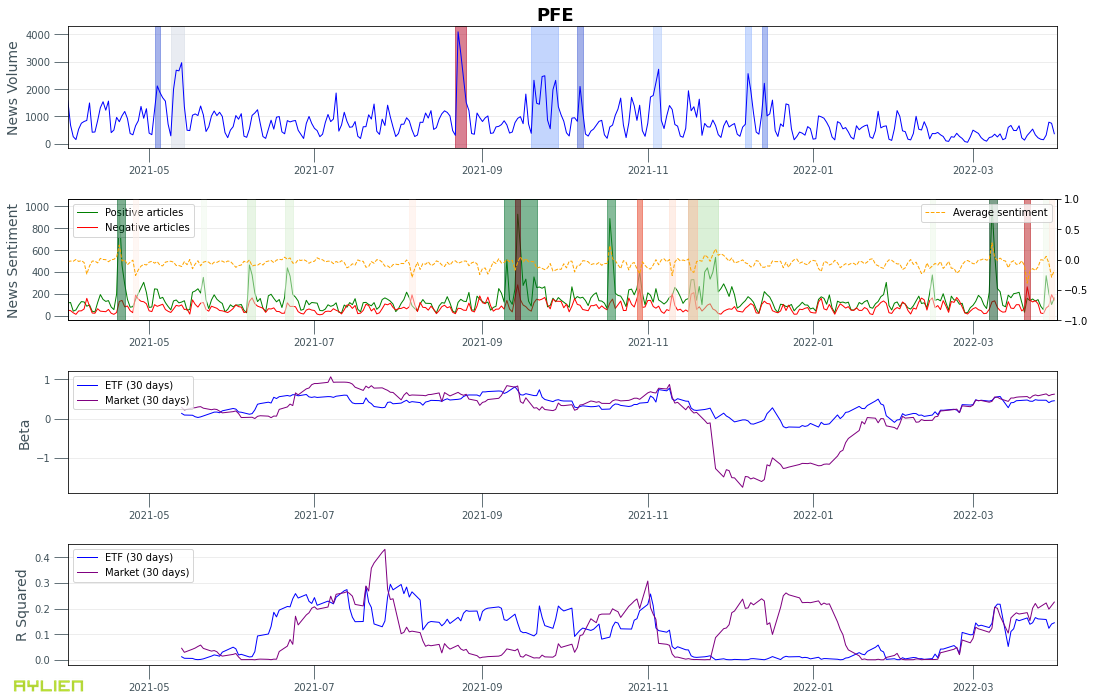

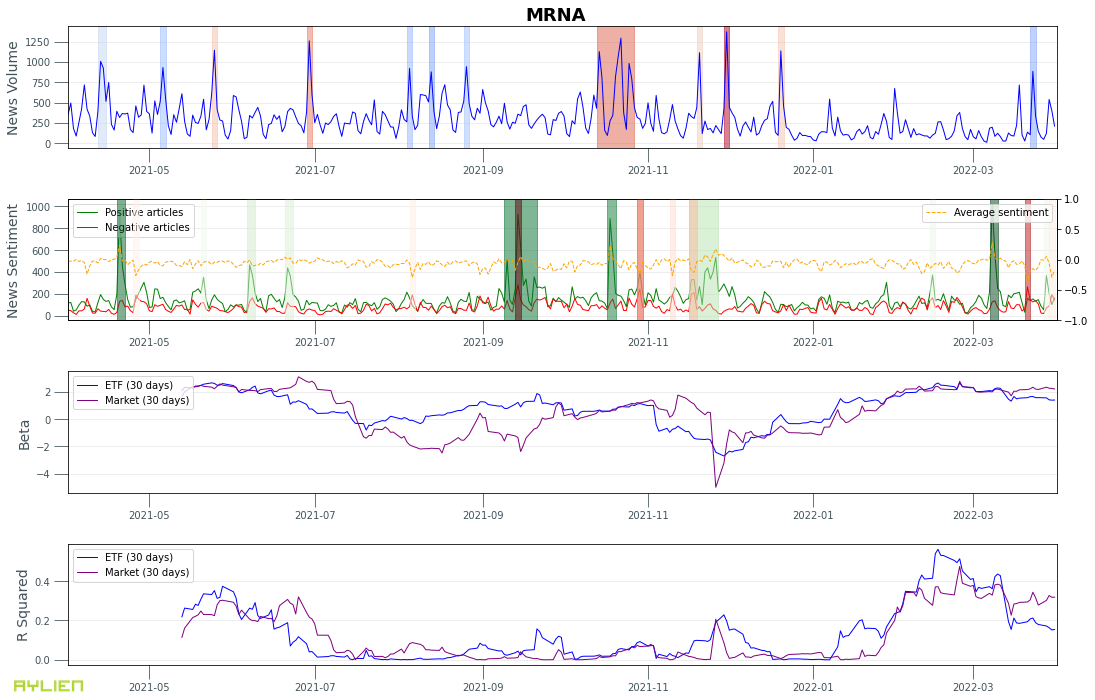

In [ ]:
# Plot news data vs rolling beta and r squared for each ticker
from datetime import datetime


for ticker in ["AAPL", "TSLA", "PFE", "MRNA"]:
    newsv_df = data[ticker]["news"]["volume_df"]
    newssp_df = data[ticker]["news"]["sentiment-positive_df"]
    newssn_df = data[ticker]["news"]["sentiment-negative_df"]
    newssavg_df = data[ticker]["news"]["sentiment-average_df"]
    market_df = data[ticker]["market"]

    newsv_ts = data[ticker]["news"]["volume_ts"]
    newssp_ts = data[ticker]["news"]["sentiment-positive_ts"]
    newssn_ts = data[ticker]["news"]["sentiment-negative_ts"]
    newssavg_ts = data[ticker]["news"]["sentiment-average_ts"]
  
    price_ts = data[ticker]["market_ts"]["price_ts"]
    volume_ts = data[ticker]["market_ts"]["volume_ts"]

    # match tickers with good sector ETFs
    if ticker in ["AAPL", "TSLA"]:
        etf = "XLK"
    else:
        etf = "XPH"

    brsq_etf = calc_beta_rsquared(data[ticker]["market"]["Adj Close"], data[etf]["market"]["Adj Close"],window=30)
    brsq_market = calc_beta_rsquared(data[ticker]["market"]["Adj Close"], data["^GSPC"]["market"]["Adj Close"],window=30)

    wois = []
    for ts in [newsv_ts, newssp_ts, newssn_ts, newssavg_ts, volume_ts]:
        interesting_windows, weights = detector.windows_of_interest(
            ts,
            whisker_width=1.5,
            window_range=1,
            min_delta=5
        )
        wois.append((interesting_windows, weights))

    for ts in [price_ts]:
        decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
        decomposed = decomposer.decomposer()

        interesting_windows, weights = detector.windows_of_interest(
            decomposed['rem'],
            whisker_width=1,
            window_range=1,
            min_delta=5,
            min_iqr=2
        )
        wois.append((interesting_windows, weights))

    plt.rc('figure', figsize=(15, 10))

    fig, axes = plt.subplots(4, 1)
    fig.tight_layout(pad=3)
    fig.suptitle(ticker, fontweight='bold', fontsize=18)
    fig.figimage(im, 10, 0, zorder=3, alpha=.8)

    plot_newsv = axes[0]
    plot_newsv.tick_params(axis='both', **config_ticks)
    plot_newsv.set_ylabel('News Volume', fontsize=14)
    plot_newsv.yaxis.label.set_color(colors['grey'])
    plot_newsv.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_newsv.set_axisbelow(True)
    plot_newsv.plot(newsv_df['count'], color='blue', linewidth=1, label='News volume')
    # add windows of interest
    for (start, end), weight in zip(wois[0][0], wois[0][1]):
        plot_newsv.axvspan(mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
                mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
                color=cmap(weight), alpha=0.5)
    plot_newsv.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])

    plot_newss = axes[1]
    plot_newss.tick_params(axis='both', **config_ticks)
    plot_newss.set_ylabel('News Sentiment', fontsize=14)
    plot_newss.yaxis.label.set_color(colors['grey'])
    plot_newss.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_newss.set_axisbelow(True)
    plot_newss.plot(newssp_df['count'], color='green', linewidth=1, label='Positive articles')
    plot_newss.plot(newssn_df['count'], color='red', linewidth=1, label='Negative articles')
    plot_newss.legend(loc="upper left")
    plot_newss.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])

    plot_newssavg = plot_newss.twinx()
    plot_newssavg.plot(newssavg_df['count'], color='orange', linewidth=1, label='Average sentiment', ls='--')
    plot_newssavg.axes.set_ylim(-1,1)
    plot_newssavg.legend(loc="upper right")
    # add windows of interest
    for (start, end), weight in zip(wois[1][0], wois[1][1]):
        plot_newssavg.axvspan(mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
                mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
                color=matplotlib.cm.Greens(weight), alpha=0.5)
    for (start, end), weight in zip(wois[2][0], wois[2][1]):
        plot_newssavg.axvspan(mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
                mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
                color=matplotlib.cm.Reds(weight), alpha=0.5)
    plot_newssavg.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])

    plot_beta = axes[2]
    plot_beta.tick_params(axis='both', **config_ticks)
    plot_beta.set_ylabel('Beta', fontsize=14)
    plot_beta.yaxis.label.set_color(colors['grey'])
    plot_beta.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_beta.set_axisbelow(True)
    plot_beta.plot(brsq_etf[0], color='blue', linewidth=1, label='ETF (30 days)')
    plot_beta.plot(brsq_market[0], color='purple', linewidth=1, label='Market (30 days)')
    plot_beta.legend(loc="upper left")
    plot_beta.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])

    plot_rsquared = axes[3]
    plot_rsquared.tick_params(axis='both', **config_ticks)
    plot_rsquared.set_ylabel('R Squared', fontsize=14)
    plot_rsquared.yaxis.label.set_color(colors['grey'])
    plot_rsquared.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_rsquared.set_axisbelow(True)
    plot_rsquared.plot(brsq_etf[1], color='blue', linewidth=1, label='ETF (30 days)')
    plot_rsquared.plot(brsq_market[1], color='purple', linewidth=1, label='Market (30 days)')
    plot_rsquared.legend(loc="upper left")
    plot_rsquared.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])

# 2.5. Events

Let's see if we can find any correlations between market data and specific event types such as M&A or analyst events. We use events as a useful decomposition of news volume data.

In [ ]:
# Specify events of interest using the Smart Tagger taxonomy

interesting_events = [
  ("ay.biz.newprod", "New Products"),
  ("ay.biz.layoffs", "Layoffs"),
  ("ay.fin.analyst", "Analyst Comments"),
  ("ay.fin.stocks", "Stocks"),
  ("ay.fin.reports", "Corporate Earnings"),
  ("ay.biz.manda", "Mergers & Acquisitions"),
  ("ay.biz.expand", "Store Openings")
]

aapl_aql = "entities:({{id:Q312 AND element:title}})"

events_ts = []

for event in interesting_events:
    print(f"Fetching news volume time series data for AAPL and \"{event[1]}\"")
    query = {**base_query, **{"aql": aapl_aql + " AND " + "categories:{{taxonomy:aylien AND id:"+event[0]+"}}"}}
    time_series = retrieve_timeseries(query)
    apple_df = pd.DataFrame(time_series["time_series"])
    apple_df = apple_df.astype({'published_at': 'datetime64[ns]', 'count': 'float'}, copy=False)
    apple_df.set_index('published_at', inplace=True)
    events_ts.append(apple_df)

Fetching news volume time series data for AAPL and "New Products"
Fetching news volume time series data for AAPL and "Layoffs"
Fetching news volume time series data for AAPL and "Analyst Comments"
Fetching news volume time series data for AAPL and "Stocks"
Fetching news volume time series data for AAPL and "Corporate Earnings"
Fetching news volume time series data for AAPL and "Mergers & Acquisitions"
Fetching news volume time series data for AAPL and "Store Openings"


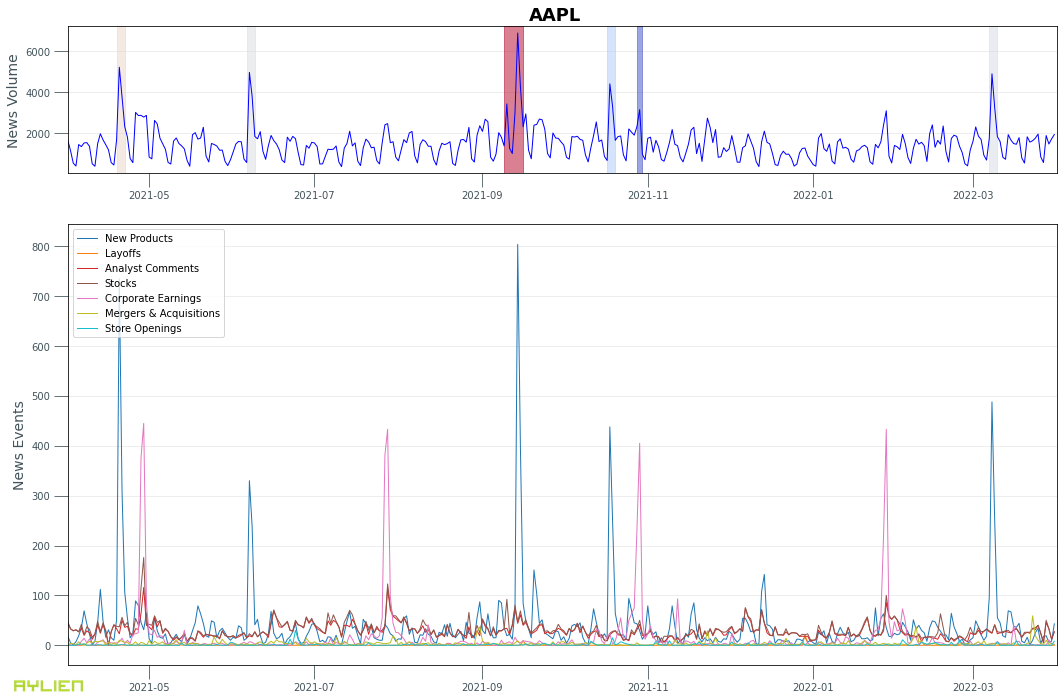

In [ ]:
# Show breakdown of news volume by event type for AAPL

import numpy as np

for ticker in ["AAPL"]:
    newsv_df = data[ticker]["news"]["volume_df"]
    newssp_df = data[ticker]["news"]["sentiment-positive_df"]
    newssn_df = data[ticker]["news"]["sentiment-negative_df"]
    newssavg_df = data[ticker]["news"]["sentiment-average_df"]

    newsv_ts = data[ticker]["news"]["volume_ts"]
    newssp_ts = data[ticker]["news"]["sentiment-positive_ts"]
    newssn_ts = data[ticker]["news"]["sentiment-negative_ts"]
    newssavg_ts = data[ticker]["news"]["sentiment-average_ts"]
  
    wois = []

    for ts in [newsv_ts, newssp_ts, newssn_ts, newssavg_ts]:
        interesting_windows, weights = detector.windows_of_interest(
            ts,
            whisker_width=1.5,
            window_range=1,
            min_delta=5
        )
        wois.append((interesting_windows, weights))

    plt.rc('figure', figsize=(15, 10))

    fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]})
    fig.tight_layout(pad=3)
    fig.suptitle(ticker, fontweight='bold', fontsize=18)
    fig.figimage(im, 10, 0, zorder=3, alpha=.8)

    plot_newsv = axes[0]
    plot_newsv.tick_params(axis='both', **config_ticks)
    plot_newsv.set_ylabel('News Volume', fontsize=14)
    plot_newsv.yaxis.label.set_color(colors['grey'])
    plot_newsv.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_newsv.set_axisbelow(True)
    plot_newsv.plot(newsv_df['count'], color='blue', linewidth=1, label='News volume')
    # add windows of interest
    for (start, end), weight in zip(wois[0][0], wois[0][1]):
        plot_newsv.axvspan(mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
                mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
                color=cmap(weight), alpha=0.5)
    plot_newsv.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])

    plot_newse = axes[1]
    plot_newse.tick_params(axis='both', **config_ticks)
    plot_newse.set_ylabel('News Events', fontsize=14)
    plot_newse.yaxis.label.set_color(colors['grey'])
    plot_newse.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_newse.set_axisbelow(True)
    for i, ets in enumerate(events_ts):
        color = np.linspace(0, 1, 7)[i]
        plot_newse.plot(ets['count'], color=matplotlib.cm.tab10(color), linewidth=1, label=interesting_events[i][1])
    plot_newse.legend(loc="upper left")
    plot_newse.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])

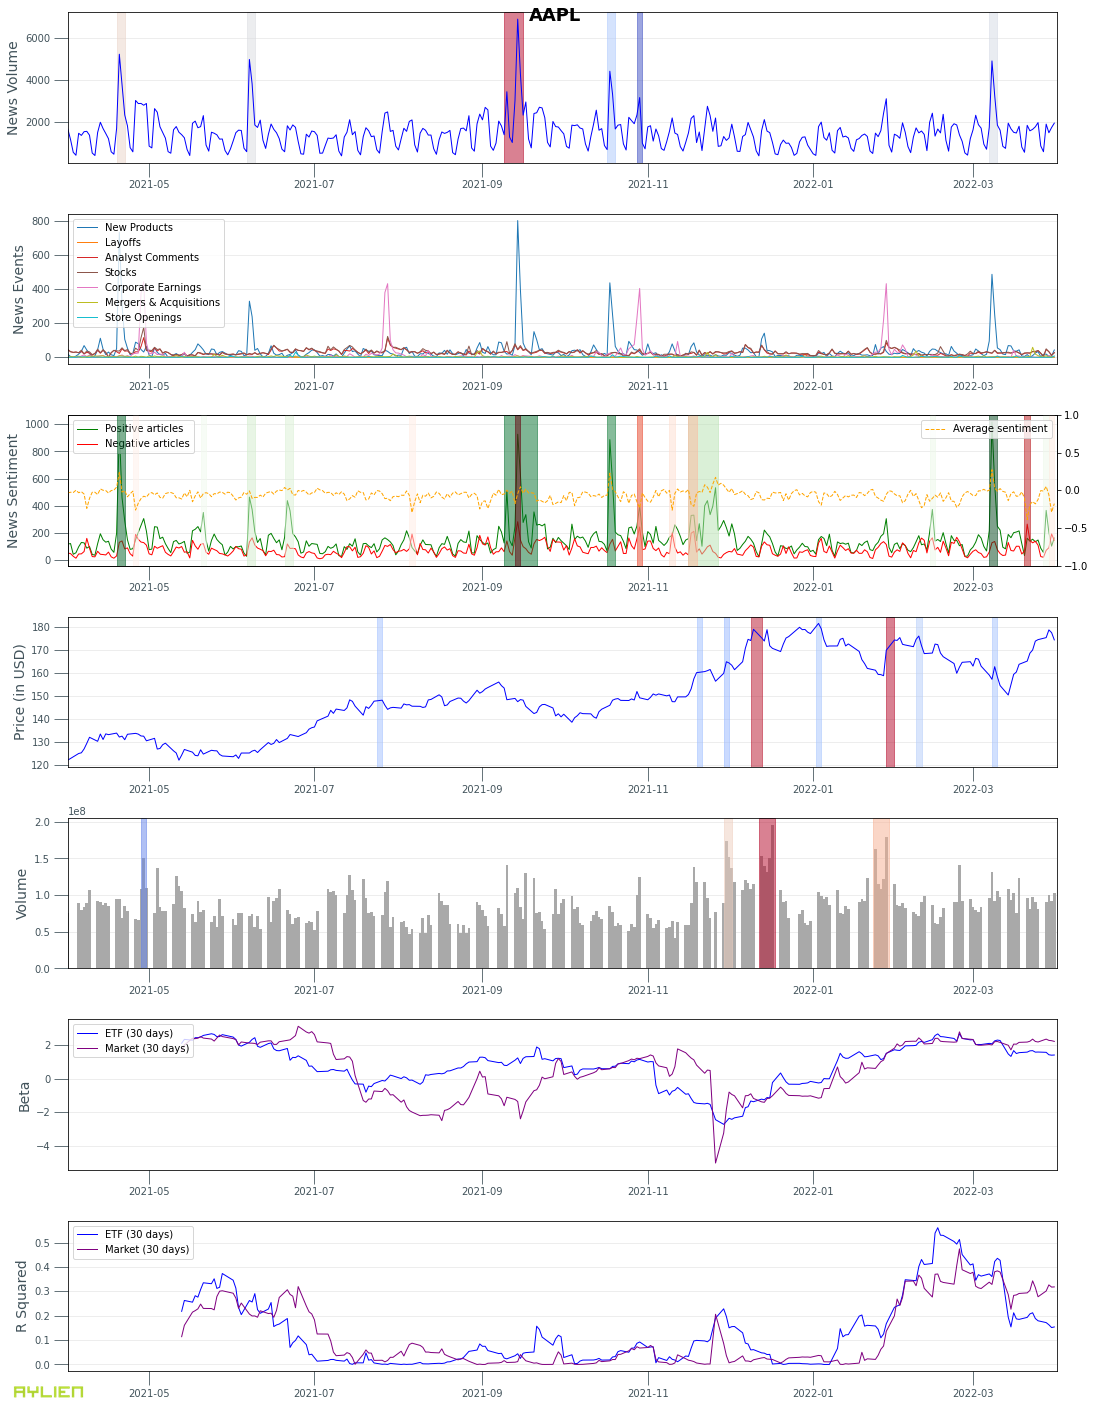

In [ ]:
# Putting it all together...

for ticker in ["AAPL"]:
    newsv_df = data[ticker]["news"]["volume_df"]
    newssp_df = data[ticker]["news"]["sentiment-positive_df"]
    newssn_df = data[ticker]["news"]["sentiment-negative_df"]
    newssavg_df = data[ticker]["news"]["sentiment-average_df"]
    market_df = data[ticker]["market"]

    newsv_ts = data[ticker]["news"]["volume_ts"]
    newssp_ts = data[ticker]["news"]["sentiment-positive_ts"]
    newssn_ts = data[ticker]["news"]["sentiment-negative_ts"]
    newssavg_ts = data[ticker]["news"]["sentiment-average_ts"]
  
    price_ts = data[ticker]["market_ts"]["price_ts"]
    volume_ts = data[ticker]["market_ts"]["volume_ts"]

    wois = []

    for ts in [newsv_ts, newssp_ts, newssn_ts, newssavg_ts, volume_ts]:
        interesting_windows, weights = detector.windows_of_interest(
            ts,
            whisker_width=1.5,
            window_range=1,
            min_delta=5
        )
        wois.append((interesting_windows, weights))

    for ts in [price_ts]:
        decomposer = TimeSeriesDecomposition(ts, decomposition="additive")
        decomposed = decomposer.decomposer()

        interesting_windows, weights = detector.windows_of_interest(
            decomposed['rem'],
            whisker_width=1,
            window_range=1,
            min_delta=5,
            min_iqr=2
        )
        wois.append((interesting_windows, weights))

    plt.rc('figure', figsize=(15, 20))

    fig, axes = plt.subplots(7, 1)
    fig.tight_layout(pad=3)
    fig.suptitle(ticker, fontweight='bold', fontsize=18)
    fig.figimage(im, 10, 0, zorder=3, alpha=.8)

    plot_newsv = axes[0]
    plot_newsv.tick_params(axis='both', **config_ticks)
    plot_newsv.set_ylabel('News Volume', fontsize=14)
    plot_newsv.yaxis.label.set_color(colors['grey'])
    plot_newsv.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_newsv.set_axisbelow(True)
    plot_newsv.plot(newsv_df['count'], color='blue', linewidth=1, label='News volume')
    # add windows of interest
    for (start, end), weight in zip(wois[0][0], wois[0][1]):
        plot_newsv.axvspan(mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
                mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
                color=cmap(weight), alpha=0.5)
    plot_newsv.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])

    plot_newse = axes[1]
    plot_newse.tick_params(axis='both', **config_ticks)
    plot_newse.set_ylabel('News Events', fontsize=14)
    plot_newse.yaxis.label.set_color(colors['grey'])
    plot_newse.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_newse.set_axisbelow(True)
    for i, ets in enumerate(events_ts):
        color = np.linspace(0, 1, 7)[i]
        plot_newse.plot(ets['count'], color=matplotlib.cm.tab10(color), linewidth=1, label=interesting_events[i][1])
    plot_newse.legend(loc="upper left")
    plot_newse.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])

    plot_newss = axes[2]
    plot_newss.tick_params(axis='both', **config_ticks)
    plot_newss.set_ylabel('News Sentiment', fontsize=14)
    plot_newss.yaxis.label.set_color(colors['grey'])
    plot_newss.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_newss.set_axisbelow(True)
    plot_newss.plot(newssp_df['count'], color='green', linewidth=1, label='Positive articles')
    plot_newss.plot(newssn_df['count'], color='red', linewidth=1, label='Negative articles')
    plot_newss.legend(loc="upper left")
    plot_newss.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])

    plot_newssavg = plot_newss.twinx()
    plot_newssavg.plot(newssavg_df['count'], color='orange', linewidth=1, label='Average sentiment', ls='--')
    plot_newssavg.axes.set_ylim(-1,1)
    plot_newssavg.legend(loc="upper right")
    # add windows of interest
    for (start, end), weight in zip(wois[1][0], wois[1][1]):
        plot_newssavg.axvspan(mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
                mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
                color=matplotlib.cm.Greens(weight), alpha=0.5)
    for (start, end), weight in zip(wois[2][0], wois[2][1]):
        plot_newssavg.axvspan(mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
                mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
                color=matplotlib.cm.Reds(weight), alpha=0.5)
    plot_newssavg.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])

    plot_price = axes[3]
    plot_price.tick_params(axis='both', **config_ticks)
    plot_price.set_ylabel('Price (in USD)', fontsize=14)
    plot_price.yaxis.label.set_color(colors['grey'])
    plot_price.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_price.set_axisbelow(True)
    plot_price.plot(market_df["Adj Close"], color='blue', linewidth=1, label='Price')
    # add windows of interest
    for (start, end), weight in zip(wois[5][0], wois[5][1]):
        plot_price.axvspan(mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
                mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
                color=cmap(weight), alpha=0.5)
    plot_price.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])

    plot_volume = axes[4]
    plot_volume.tick_params(axis='both', **config_ticks)
    plot_volume.set_ylabel('Volume', fontsize=14)
    plot_volume.yaxis.label.set_color(colors['grey'])
    plot_volume.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_volume.set_axisbelow(True)
    plot_volume.bar(market_df.index, height=market_df["Volume"], color='darkgrey', width=1, label='Volume')
    # add windows of interest
    for (start, end), weight in zip(wois[4][0], wois[4][1]):
        plot_volume.axvspan(mdates.datestr2num(start.isoformat().split('+')[0]+'Z'),
                mdates.datestr2num(end.isoformat().split('+')[0]+'Z'),
                color=cmap(weight), alpha=0.5)
    plot_volume.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])
      
    plot_beta = axes[5]
    plot_beta.tick_params(axis='both', **config_ticks)
    plot_beta.set_ylabel('Beta', fontsize=14)
    plot_beta.yaxis.label.set_color(colors['grey'])
    plot_beta.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_beta.set_axisbelow(True)
    plot_beta.plot(brsq_etf[0], color='blue', linewidth=1, label='ETF (30 days)')
    plot_beta.plot(brsq_market[0], color='purple', linewidth=1, label='Market (30 days)')
    plot_beta.legend(loc="upper left")
    plot_beta.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])

    plot_rsquared = axes[6]
    plot_rsquared.tick_params(axis='both', **config_ticks)
    plot_rsquared.set_ylabel('R Squared', fontsize=14)
    plot_rsquared.yaxis.label.set_color(colors['grey'])
    plot_rsquared.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_rsquared.set_axisbelow(True)
    plot_rsquared.plot(brsq_etf[1], color='blue', linewidth=1, label='ETF (30 days)')
    plot_rsquared.plot(brsq_market[1], color='purple', linewidth=1, label='Market (30 days)')
    plot_rsquared.legend(loc="upper left")
    plot_rsquared.set_xlim([datetime.strptime(start_date, '%Y-%m-%d'), datetime.strptime(end_date, '%Y-%m-%d')])